In [2]:
# activate autoreload
%load_ext autoreload
%autoreload 2

# add src path to the notebook
import os
import sys
PROJECT_ROOT: str = os.path.dirname(os.path.abspath(os.path.dirname("__file__")))
if PROJECT_ROOT not in sys.path:
    sys.path.append(os.path.join(PROJECT_ROOT))
print(PROJECT_ROOT)

/mnt/c/Users/DavidHanny/OneDrive - IT U interdisciplinary transformation university austria/Documents/projects/papers/2025_GSAI_RES_Relevance_Classification


# Labelling Preparation
In this notebook, we prepare our three data sets for labelling by (1) sampling it accordingly and (2) utilising GPT-4 to compute preliminary labels. 

In [3]:
import os
import logging
import duckdb
import shapely
import numpy as np
import pandas as pd
import polars as pl
import geopandas as gpd
import contextily as ctx
import seaborn as sns
from collections import Counter
from tqdm import tqdm
from src.prompts import few_shot_relevance_prompt, classify_tweet_few_shot
from src.utils import top_k_lang_distribution, detect_language_fast
from fast_langdetect import detect, DetectError
tqdm.pandas()
sns.set_style('whitegrid')

# set data path
DATA_PATH: str = os.path.join(PROJECT_ROOT, 'data')
print(f'Data path: {DATA_PATH}')

Data path: /mnt/c/Users/DavidHanny/OneDrive - IT U interdisciplinary transformation university austria/Documents/projects/papers/2025_GSAI_RES_Relevance_Classification/data


To provide a unified framework, let's store the metadata on our files in a dictionary.

In [3]:
files: dict = {
    'chile': {
        'path': os.path.join(DATA_PATH, 'processed', 'use_cases', 'chile', 'chile_tweets_to_label.parquet'),
    },
    'ahr_valley': {
        'path': os.path.join(DATA_PATH, 'processed', 'use_cases', 'ahr_valley', 'ahr_valley_tweets_to_label.parquet'),
    },
    'emilia_romagna': {
        'path': os.path.join(DATA_PATH, 'processed', 'use_cases', 'emilia_romagna', 'emilia_romagna_tweets_to_label.parquet'),
    },
    'california': {
        'path': os.path.join(DATA_PATH, 'processed', 'use_cases', 'california', 'california_tweets_to_label.parquet'),
    },
    'turkey': {
        'path': os.path.join(DATA_PATH, 'processed', 'use_cases', 'turkey', 'turkey_tweets_to_label.parquet'),
    }
}

for file in files.keys():
    print(f'{file}: {"found" if os.path.exists(files[file]["path"]) else "not found"}')

chile: found
ahr_valley: found
emilia_romagna: found
california: found
turkey: found


## 1. Few-shot Examples
We then need some few-shot examples from the Ahr Valley data to inject into our few-shot labelling prompt.

In [4]:
ahr_valley_gdf: gpd.GeoDataFrame = gpd.read_parquet(files['ahr_valley']['path'])
for category in ahr_valley_gdf['category'].unique().tolist():
    if category is not None:
        print(category)
        sample: list[str] = ahr_valley_gdf[ahr_valley_gdf["category"] == category].sample(2)['text'].tolist()
        for text in sample:
            print(f'- {text}')

4 - nicht relevant
- @user Morgen bei jetzt 14.5℃, bedeckt/leichter Regen, Wind SW 2 bft, Luftdruck 1009 mbar, Niederschlagsrisiko 75% aus 55599 Siefersheim in Rheinhessen. http
- Niederschlag (Intensität 5/10, Fläche 9/10)http(11.07.21 08:12) #München #Minga http
3 - wenig relevant
- @user @user @user Oder wie @user selbst gestern im Interview sagt:"Schon morgens, als die Sonne noch schien und niemand (=also #Laschet nicht) mit Regen rechnen konnte, hat die Feuerwehr sich auf eine Katastrophe vorbereitet." Weil die Leute vor Ort im Ggs. zu ihm wissen, was sie tun.
- Mein Beileid allen Angehörigen die eine geliebte Person verlieren mussten, meine Gedanken bei jenen die um ihre Lieben noch bangen müssen, bei all den Helfer:innen die seit Tagen unermüdlich im Einsatz stehen. Was für eine riesen Katastrophe. http
1 - sehr relevant
- #Ahrweiler #Hochwasserkatastrophe #Hilfsgesuch Es wird in Ahrweiler dringend gebraucht: Hänger mit Wassertanks, Wasserbehälter, Motorsäge, Minibagger, Stromge

In [5]:
chile_gdf: gpd.GeoDataFrame = gpd.read_parquet(files['chile']['path'])
for relatedness in chile_gdf['related'].unique().tolist():
    if relatedness is not None and not np.isnan(relatedness):
        print(relatedness)
        sample: list[str] = chile_gdf[chile_gdf["related"] == relatedness].sample(5)['text'].tolist()
        for text in sample:
            print(f'- {text}')

1.0
- @user @user 8:15 inicia el incendio y las 9:18 el incendio sigue ahi mismo... Todo bombero o brigadista sabe que un incendio forestal es muy rápida propagación en una hora fácilmente llevaría 300 metros quemados ( quizás mas ) Me da a pensar que se estaba cocinando algo...
- 12:23 en Ñiquén Fuego en pasto y/o basura (10-2) F1 CAMINO AL PEUMO CON SAN VICENTE http
- Ahora Bajo el cielo de la #Araucania #Incendio http
- @user La.h...que.llego.a.tener.un.cargo.con.los.incendios.en.ÑUBLE.se.escondio.como.raton.que.es.las.patitas.
- Da lo mismo, pasa a ser un cacho para los técnicos que guían el combate de los incendios.Única solución, PLR a éste mono fallado del mate, delincuente e ignorante a cargo de los destinos de un país.Basta de continuar aceptando un grupo de parásitos CDR estafadores y corruptos.
0.0
- 14:29 en Talca Fuego en vehículo (10-1-1) B-5 5 Oriente y Circunvalacion Norte http
- Energías renovables: Córdoba lideró el ranking de generación distribuida en 2022 http
- Un 

We ran this a few times and selected a diverse set of tweets for the few-shot prompt.

In [6]:
print(few_shot_relevance_prompt(ahr_valley_gdf.sample(1)['text'].values[0]))

Your job is to classify tweets in the three categories "Related and relevant", "Related but not relevant", and "Not related" in the context of floods and wildfires.

Here is some more information about the categories:
- "Related and relevant": The tweet is related to floods or wildfires and contains information that is helpful for disaster managers (e.g. affected individuals, emergencies, damaged infrastructure, reqests for help and other contextual information)
- "Related but not relevant": The tweet is related to floods or wildfires but does not contain information that is helpful for disaster managers (e.g. general information, opinions, etc.)
- "Not related": The tweet is not related to floods or wildfires.

Here are some examples (partly in German):
- Tweet: "Here the entire street is under water. Water higher than the curb and the car entrance. The cellars are probably full too. #unwetter #cologne #bickendorf"
Label: "Related and relevant"
- Tweet: "ATTENTION! Due to forest fire,

## 2. GPT-based labelling
Next, let's label some tweets with our GPT-4o-mini setup. We do this using our joint dataset that we have built based on relatedness.

In [4]:
tweet_gdf: gpd.GeoDataFrame = gpd.GeoDataFrame()
for use_case in files:
    # read in each file
    read_gdf: gpd.GeoDataFrame = gpd.read_parquet(files[use_case]['path'])
    print(f'{use_case}: {read_gdf.shape}')
    read_gdf['use_case'] = use_case

    # concatenate with existing tweets
    tweet_gdf = pd.concat([tweet_gdf, read_gdf])

# clean and print the results
tweet_gdf = tweet_gdf.drop(columns=['level_0', 'index'])
tweet_gdf = tweet_gdf.reset_index(drop=True)
print(tweet_gdf.shape)
tweet_gdf.head()

chile: (10000, 14)
ahr_valley: (3992, 15)
emilia_romagna: (3834, 14)
california: (10000, 11)
turkey: (10000, 14)
(37826, 14)


,message_id,date,text,tweet_lang,geom,photo_url,text_raw,related,centroid,x,y,text_en,use_case,category
0,1616045924605739008,2023-01-19 12:12:27,@user La cara de pelotudos q les quedará a muc...,es,POINT (-68.46836 -33.08063),None,@Gracielamafald2 La cara de pelotudos q les qu...,0,POINT (-7621862.971 -3906010.546),-7.621863e+06,-3.906011e+06,@user The look of idiocy that many will have o...,chile,NaN
1,1620985923226959872,2023-02-02 03:22:15,"@user @user Se ve q están cerca,cuidado chicos",es,POINT (-71.51565 -33.02636),None,"@neme_munoz @jocee__g Se ve q están cerca,cuid...",0,POINT (-7961085.296 -3898803.003),-7.961085e+06,-3.898803e+06,"@user @user It seems that they are close, be c...",chile,NaN
2,1632606303896981504,2023-03-06 04:57:29,@user Jamas te haría eso,es,POINT (-69.64635 -49.19601),None,@frqnnaranda Jamas te haría eso,0,POINT (-7752996.496 -6308186.127),-7.752996e+06,-6.308186e+06,@user I would never do that to you,chile,NaN
3,1634705695672025092,2023-03-11 23:59:43,@user Conversa muy amena y risas por doquier c...,es,POINT (-70.61076 -33.42949),None,@La_TurcaPorfia Conversa muy amena y risas por...,0,POINT (-7860353.736 -3952450.655),-7.860354e+06,-3.952451e+06,@user Very pleasant conversation and laughter ...,chile,NaN
4,1619365408133492737,2023-01-28 16:02:54,@user por pedofilo???...a muy bien ....,es,POINT (-70.65962 -33.45216),None,@ViralizandoAndo por pedofilo???...a muy bien ...,0,POINT (-7865792.417 -3955475.786),-7.865792e+06,-3.955476e+06,@user for pedophile???...very well....,chile,NaN


In [5]:
tweet_gdf.groupby('related').size()

related
0    14850
1    22976
dtype: int64

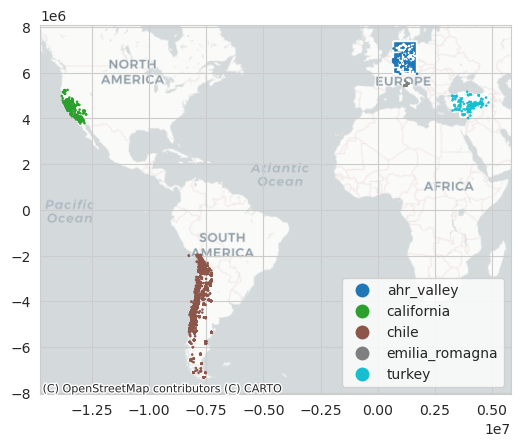

In [48]:
ax = tweet_gdf.to_crs(3857).plot(markersize=0.7, column='use_case', legend=True)
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)

Good, I guess we can now go ahead and apply the labelling procedure. We use GPT-4o-mini for the realisation due to the following cost estimation from [this website](https://livechatai.com/gpt-4o-pricing-calculator). Our input tokens will range from 888-1100 and the outputs token are all <= 8.
- GPT-4o: 90-100$
- GPT-4o-mini: 6-8$

In [7]:
tweet_gdf['gpt4omini_label'] = tweet_gdf['text'].progress_apply(lambda x: classify_tweet_few_shot(text=x, openai_key=os.environ.get('openai_key'), model='gpt-4o-mini'))
tweet_gdf.groupby('gpt4omini_label').size()

100%|██████████| 37826/37826 [66:46:30<00:00,  6.36s/it]   


gpt4omini_label
Not related                 21234
Related and relevant         7816
Related but not relevant     8776
dtype: int64

In [8]:
tweet_gdf.to_parquet(os.path.join(DATA_PATH, 'processed', 'use_cases', 'relevance_tweets_to_label_full.parquet'))

## 3. Labelling Subset
The GPT-4o-mini based labelling procedure cost us about 8$. Due to rate limits, it took 66 hours. I therefore ran it on a dedicated server.

In [5]:
tweet_gdf: gpd.GeoDataFrame = gpd.read_parquet(os.path.join(DATA_PATH, 'processed', 'use_cases', 'relevance_tweets_to_label_full.parquet'))
print(tweet_gdf.shape)
print(tweet_gdf.groupby('gpt4omini_label').size())
tweet_gdf.head()

(37826, 15)
gpt4omini_label
Not related                 21234
Related and relevant         7816
Related but not relevant     8776
dtype: int64


,message_id,date,text,tweet_lang,geom,photo_url,text_raw,related,centroid,x,y,text_en,use_case,category,gpt4omini_label
0,1616045924605739008,2023-01-19 12:12:27,@user La cara de pelotudos q les quedará a muc...,es,POINT (-68.46836 -33.08063),None,@Gracielamafald2 La cara de pelotudos q les qu...,0,POINT (-7621862.971 -3906010.546),-7.621863e+06,-3.906011e+06,@user The look of idiocy that many will have o...,chile,None,Not related
1,1620985923226959872,2023-02-02 03:22:15,"@user @user Se ve q están cerca,cuidado chicos",es,POINT (-71.51565 -33.02636),None,"@neme_munoz @jocee__g Se ve q están cerca,cuid...",0,POINT (-7961085.296 -3898803.003),-7.961085e+06,-3.898803e+06,"@user @user It seems that they are close, be c...",chile,None,Not related
2,1632606303896981504,2023-03-06 04:57:29,@user Jamas te haría eso,es,POINT (-69.64635 -49.19601),None,@frqnnaranda Jamas te haría eso,0,POINT (-7752996.496 -6308186.127),-7.752996e+06,-6.308186e+06,@user I would never do that to you,chile,None,Not related
3,1634705695672025092,2023-03-11 23:59:43,@user Conversa muy amena y risas por doquier c...,es,POINT (-70.61076 -33.42949),None,@La_TurcaPorfia Conversa muy amena y risas por...,0,POINT (-7860353.736 -3952450.655),-7.860354e+06,-3.952451e+06,@user Very pleasant conversation and laughter ...,chile,None,Not related
4,1619365408133492737,2023-01-28 16:02:54,@user por pedofilo???...a muy bien ....,es,POINT (-70.65962 -33.45216),None,@ViralizandoAndo por pedofilo???...a muy bien ...,0,POINT (-7865792.417 -3955475.786),-7.865792e+06,-3.955476e+06,@user for pedophile???...very well....,chile,None,Not related


Let's also see the distribution of labels per use case.

In [7]:
tweet_gdf.groupby(['use_case', 'gpt4omini_label']).size()

use_case        gpt4omini_label         
ahr_valley      Not related                 2016
                Related and relevant         589
                Related but not relevant    1387
california      Not related                 4737
                Related and relevant        2625
                Related but not relevant    2638
chile           Not related                 6163
                Related and relevant        2028
                Related but not relevant    1809
emilia_romagna  Not related                 3433
                Related and relevant         219
                Related but not relevant     182
turkey          Not related                 4885
                Related and relevant        2355
                Related but not relevant    2760
dtype: int64

For our human labelling, we take <= 350 posts per class and use case.

In [17]:
tweet_gdf.groupby('gpt4omini_label').size().min()

7816

In [24]:
MAX_SAMPLE_SIZE: int = 350
RANDOM_STATE: int = 42

# build a sampled dataframe
label_gdf: gpd.GeoDataFrame = gpd.GeoDataFrame()
for use_case in tweet_gdf['use_case'].unique():
    use_case_gdf: gpd.GeoDataFrame = tweet_gdf[tweet_gdf['use_case'] == use_case]

    # first, we need to define the sample size based on the use case
    sample_size = use_case_gdf.groupby(['gpt4omini_label']).size().min()
    if sample_size > MAX_SAMPLE_SIZE:
        sample_size = MAX_SAMPLE_SIZE

    # with that information, we can draw the samples
    for label in tweet_gdf['gpt4omini_label'].unique():
        filtered_gdf: gpd.GeoDataFrame = tweet_gdf[(tweet_gdf['use_case'] == use_case) & (tweet_gdf['gpt4omini_label'] == label)]
        label_gdf = pd.concat([label_gdf, filtered_gdf.sample(sample_size, random_state=RANDOM_STATE)], ignore_index=True)

print(label_gdf.groupby(['use_case', 'gpt4omini_label']).size())
label_gdf.head()

use_case        gpt4omini_label         
ahr_valley      Not related                 350
                Related and relevant        350
                Related but not relevant    350
california      Not related                 350
                Related and relevant        350
                Related but not relevant    350
chile           Not related                 350
                Related and relevant        350
                Related but not relevant    350
emilia_romagna  Not related                 182
                Related and relevant        182
                Related but not relevant    182
turkey          Not related                 350
                Related and relevant        350
                Related but not relevant    350
dtype: int64


,message_id,date,text,tweet_lang,geom,photo_url,text_raw,related,centroid,x,y,text_en,use_case,category,gpt4omini_label
0,1638447129516556289,2023-03-22 07:46:51,@user Quíhuboo,es,POINT (-68.33042 -34.62042),None,@sanchezzdiegoo Quíhuboo,0,POINT (-7606507.783 -4112416.698),-7.606508e+06,-4.112417e+06,@user Quíhuboo,chile,None,Not related
1,1632119844228280333,2023-03-04 20:44:28,Cómo extraño ir a la aristides a ver los parti...,es,POINT (-68.86669 -32.88334),None,Cómo extraño ir a la aristides a ver los parti...,0,POINT (-7666204.585 -3879829.849),-7.666205e+06,-3.879830e+06,How I miss going to Aristides to watch the gam...,chile,None,Not related
2,1613512905240252416,2023-01-12 12:27:08,Verdad que tembló anoche 😱,es,POINT (-70.31893 -32.95485),None,Verdad que tembló anoche 😱,1,POINT (-7827867.264 -3889312.084),-7.827867e+06,-3.889312e+06,It really shook last night 😱,chile,None,Not related
3,1627487316410261506,2023-02-20 01:56:28,Es un robo de agua pohhhhhhh,es,POINT (-71.39758 -35.96602),None,Es un robo de agua pohhhhhhh,1,POINT (-7947942.472 -4295946.371),-7.947942e+06,-4.295946e+06,"It's a water theft, pohhhhhhh",chile,None,Not related
4,1620448640325279745,2023-01-31 15:47:16,@user Temazo ese,es,POINT (-70.63852 -33.36638),None,@anakarinagcm Temazo ese,0,POINT (-7863444.522 -3944036.301),-7.863445e+06,-3.944036e+06,@user That's a great song,chile,None,Not related


In [30]:
label_gdf.to_parquet(os.path.join(DATA_PATH, 'processed', 'labelling', 'relevance_sample_to_label.parquet'))

Alright, so let's save this and prepare the Excel sheet. We need to convert the geometries first though.

In [31]:
label_df: pd.DataFrame = pd.DataFrame(label_gdf)
label_df['geom'] = gpd.GeoSeries(label_df['geom'], crs=4326).to_wkb()
label_df['centroid'] = gpd.GeoSeries(label_df['centroid'], crs=3857).to_wkb()
label_df = label_df.rename(columns={'category': 'prev_category'})
label_df.to_excel(os.path.join(DATA_PATH, 'processed', 'labelling', 'relevance_sample_to_label.xlsx'), index=False)
label_df.head()

,message_id,date,text,tweet_lang,geom,photo_url,text_raw,related,centroid,x,y,text_en,use_case,prev_category,gpt4omini_label
0,1638447129516556289,2023-03-22 07:46:51,@user Quíhuboo,es,b'\x01\x01\x00\x00\x00@\xf8P\xa2%\x15Q\xc0\x82...,None,@sanchezzdiegoo Quíhuboo,0,b'\x01\x01\x00\x00\x00w=\x18\xf2:\x04]\xc1D@bY...,-7.606508e+06,-4.112417e+06,@user Quíhuboo,chile,None,Not related
1,1632119844228280333,2023-03-04 20:44:28,Cómo extraño ir a la aristides a ver los parti...,es,b'\x01\x01\x00\x00\x00\x87\x16\xd9\xcew7Q\xc0\...,None,Cómo extraño ir a la aristides a ver los parti...,0,b'\x01\x01\x00\x00\x00\r\x99r%\x87>]\xc1\x83\x...,-7.666205e+06,-3.879830e+06,How I miss going to Aristides to watch the gam...,chile,None,Not related
2,1613512905240252416,2023-01-12 12:27:08,Verdad que tembló anoche 😱,es,b'\x01\x01\x00\x00\x00\xba!2Qi\x94Q\xc0\xde\xd...,None,Verdad que tembló anoche 😱,1,b'\x01\x01\x00\x00\x00\x8d\xb8\xdf\xd0f\xdc]\x...,-7.827867e+06,-3.889312e+06,It really shook last night 😱,chile,None,Not related
3,1627487316410261506,2023-02-20 01:56:28,Es un robo de agua pohhhhhhh,es,b'\x01\x01\x00\x00\x00\x9b\xde\xc5\xfbq\xd9Q\x...,None,Es un robo de agua pohhhhhhh,1,b'\x01\x01\x00\x00\x00\t\x117\x9e\xa9Q^\xc1\x9...,-7.947942e+06,-4.295946e+06,"It's a water theft, pohhhhhhh",chile,None,Not related
4,1620448640325279745,2023-01-31 15:47:16,@user Temazo ese,es,b'\x01\x01\x00\x00\x00\x84m\xc4\x93\xdd\xa8Q\x...,None,@anakarinagcm Temazo ese,0,b'\x01\x01\x00\x00\x00\xba\x91i!%\xff]\xc1\xea...,-7.863445e+06,-3.944036e+06,@user That's a great song,chile,None,Not related


The Excel sheet was modified to make all cells except the ones to fill uneditable (see [this tutorial](https://www.reddit.com/r/excel/comments/8brsxc/how_can_i_make_one_column_in_excel_uneditable_so/)). The password is *labelling*.

## 4. Data Statistics

In [ ]:
tweet_gdf: gpd.GeoDataFrame = gpd.read_parquet(os.path.join(DATA_PATH, 'processed', 'use_cases', 'relevance_tweets_to_label_full.parquet'))
label_gdf: gpd.GeoDataFrame = gpd.read_parquet(os.path.join(DATA_PATH, 'processed', 'labelling', 'relevance_sample_to_label.parquet'))

for use_case in tweet_gdf['use_case'].unique():
    subset: pd.DataFrame = tweet_gdf[tweet_gdf['use_case'] == use_case]

    if use_case == 'ahr_valley':
        data: gpd.GeoDataFrame = gpd.read_parquet(os.path.join(DATA_PATH, 'processed', 'use_cases', 'ahr_valley', 'ahr_valley_tweets_merged.parquet'))
        subsets = [data[data['category'].isna()], data[data['category'].notna()]]
    elif use_case == 'turkey':
        subsets = [gpd.read_parquet(os.path.join(DATA_PATH, 'processed', 'use_cases', 'turkey', 'turkey_tweets_merged.parquet'))]
    elif use_case == 'chile':
        subsets = [gpd.read_parquet(os.path.join(DATA_PATH, 'processed', 'use_cases', 'chile', 'chile_tweets_merged.parquet'))]
    elif use_case == 'california':
        subsets = [gpd.read_parquet(os.path.join(DATA_PATH, 'processed', 'use_cases', 'california', 'california_tweets_merged.parquet'))]
    elif use_case == 'emilia_romagna':
        subsets = [gpd.read_parquet(os.path.join(DATA_PATH, 'processed', 'use_cases', 'emilia_romagna', 'emilia_romagna_tweets.parquet'))]

    
    for subset in subsets:
        print('------------------------')
        print(f'{use_case}: {subset.shape[0]}')
        print(f'- Date range: {min(subset["date"])} to {max(subset["date"])}')
        if 'tweet_lang' in subset:
            print(f'- Main Languages: {subset.groupby('tweet_lang').size().sort_values(ascending=False).index.to_list()[:8]}')

            # compute and print top-5 lang distribution
            lang_dist_df = top_k_lang_distribution(subset, k=None)
            print('\n  Top 5 language distribution:')
            print(lang_dist_df.to_string(index=False, float_format="%.1f"))
            print()

        # create bounding box
        minx, miny, maxx, maxy = subset.total_bounds
        bbox: shapely.Polygon = shapely.geometry.box(minx, miny, maxx, maxy)
        wkt_bbox: str = shapely.wkt.dumps(bbox, rounding_precision=2)
        print(f'- Bounding box: {wkt_bbox}')

------------------------
chile: 1979072
- Date range: 2023-01-01 00:00:07 to 2023-06-29 17:17:39
- Main Languages: ['es', 'en', 'und', 'pt', 'qme', 'it', 'tr', 'ca']

  Top 5 language distribution:
tweet_lang   count  rel_share_pct
        es 1760804           89.0
        en   56744            2.9
       und   45301            2.3
        pt   30118            1.5
       qme   13529            0.7
        it   10041            0.5
        tr    9197            0.5
        ca    6694            0.3
        in    6392            0.3
       art    5069            0.3

- Bounding box: POLYGON ((-65.21 -56.14, -65.21 -17.32, -77.30 -17.32, -77.30 -56.14, -65.21 -56.14))
------------------------
ahr_valley: 9719
- Date range: 2021-07-01 00:00:12 to 2021-07-31 23:34:58
- Main Languages: ['de', 'en', 'und', 'in', 'pl', 'fi', 'es', 'nl']

  Top 5 language distribution:
tweet_lang  count  rel_share_pct
        de   5156           53.1
        en   2212           22.8
       und    490          

For California, we unfortunately do not have the language column from our database. One effective, yet stupid way to handle this is to use langdetect (or fast-langdetect) to estimate the language distribution.

In [3]:
CALIFORNIA_TSV_PATH: str = '/mnt/c/Users/DavidHanny/Downloads/tweets_california_2020.tsv'  # this file is on the TEMA drive
california_df: pl.DataFrame = pl.read_csv(CALIFORNIA_TSV_PATH, separator='\t')
print(california_df.shape)

(34678576, 4)


In [ ]:
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

def safe_detect(text):
    try:
        return detect(str(text))['lang']
    except DetectError:
        return "unk"
    
# grab all your texts as a list
texts = california_df["text"].to_list()

# run your detector with a progress bar
langs = []
for t in tqdm(texts, desc="Detecting tweet language"):
    langs.append(safe_detect(t))

In [ ]:
# Suppose langs is your list of detected languages:
# langs = ['en', 'es', 'en', 'fr', 'en', 'es', ...]

# 1. Count occurrences of each language
counts = Counter(langs)

# 2. Compute total number of entries
total = sum(counts.values())

# 3. Build a dict of language → fraction
fractions = {lang: count / total for lang, count in counts.items()}

# 4. (Optional) Print them sorted by fraction descending
for lang, frac in sorted(fractions.items(), key=lambda x: x[1], reverse=True):
    print(f"{lang}: {frac:.4f}")

en: 0.8834
es: 0.0264
de: 0.0149
it: 0.0074
fr: 0.0061
pt: 0.0055
ru: 0.0054
ja: 0.0045
nl: 0.0043
fi: 0.0032
pl: 0.0027
zh: 0.0027
sv: 0.0021
ceb: 0.0020
hu: 0.0016
eo: 0.0015
ar: 0.0015
ca: 0.0015
th: 0.0013
tr: 0.0012
ko: 0.0012
id: 0.0011
no: 0.0011
da: 0.0009
et: 0.0009
fa: 0.0008
tl: 0.0008
bg: 0.0007
lb: 0.0007
cs: 0.0007
eu: 0.0006
sl: 0.0005
lt: 0.0005
ro: 0.0005
uk: 0.0004
nds: 0.0004
ms: 0.0004
sr: 0.0004
kw: 0.0004
cy: 0.0004
la: 0.0004
sw: 0.0003
vi: 0.0003
jbo: 0.0003
gl: 0.0003
hr: 0.0003
fy: 0.0003
sk: 0.0002
sh: 0.0002
hi: 0.0002
sq: 0.0002
af: 0.0002
el: 0.0002
br: 0.0002
hy: 0.0002
he: 0.0002
ur: 0.0002
ie: 0.0002
oc: 0.0001
war: 0.0001
mk: 0.0001
az: 0.0001
lv: 0.0001
uz: 0.0001
km: 0.0001
nn: 0.0001
ia: 0.0001
ml: 0.0001
mn: 0.0001
tt: 0.0001
bo: 0.0001
bs: 0.0001
als: 0.0001
kn: 0.0001
ta: 0.0001
lo: 0.0001
bn: 0.0001
kk: 0.0000
ga: 0.0000
dv: 0.0000
mr: 0.0000
sco: 0.0000
si: 0.0000
io: 0.0000
mg: 0.0000
be: 0.0000
pa: 0.0000
gd: 0.0000
ast: 0.0000
arz: 0.0000
is